In [242]:
%load_ext autoreload
%autoreload 2
import priors
import waveform
import matplotlib.pyplot as plt
import numpy as np
from confusion_noise import get_threshold_and_conf_noise_for_powerlaw
from tqdm import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
!pwd

/Users/pmeyers/Repositories/gb_pop/gb_pop


In [ ]:
Tobs = 30 * 86400 # s
delta_t = 100
Nsamples = Tobs // delta_t
print(f"{Nsamples} time domain samples")
df = 1 / Tobs
times = np.arange(Tobs // delta_t)
# width of fdot Gaussian...typically the evolve 3 bins
fdot_width = 3 * df / Tobs

# Search frequencies
print(f"{df} is the frequency resolution")
fcenter = 1e-3
Nbins = 200
flow = fcenter - Nbins/2. * df
fhigh = flow + Nbins * df
search_frequencies = np.linspace(flow, fhigh - df, Nbins)

delta_f_band = search_frequencies[-1] - search_frequencies[0]

rho_th = 5

alpha = 4
Nsources = 1000 # lambda, total number of sources in band

# Fake sources
Alower = 1e-3


25920 time domain samples
3.8580246913580245e-07 is the frequency resolution


naive Ath: 0.005477753831365283


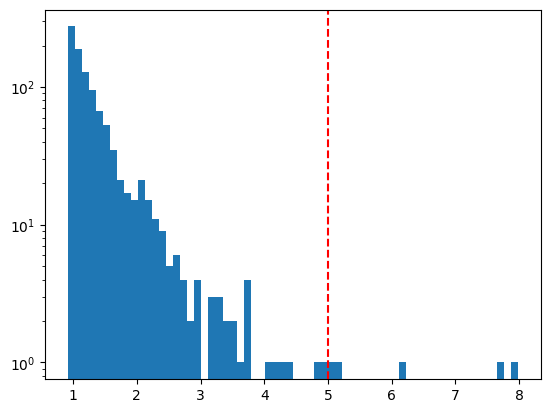

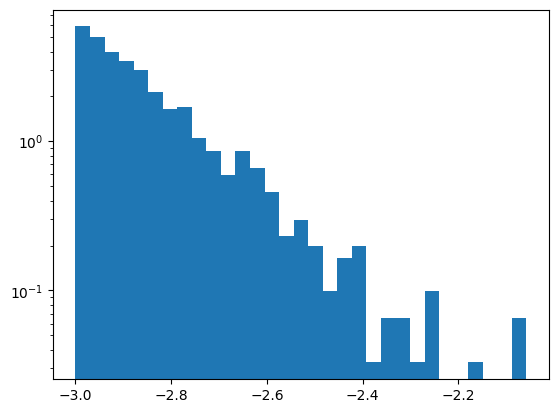

In [ ]:



source_params = {'f0': np.random.rand(Nsources) * (delta_f_band-10*df) + flow+10*df,
                 'fdot': priors.draw_from_fdot_gaussian(0, fdot_width, Nsources),
                 'A': priors.sample_power_law_bounded(4, Alower, 10, Nsources),
                 'phi0': np.random.randn(Nsources) * 2 * np.pi}

freqs = np.fft.rfftfreq(Nsamples, d=delta_t)
ilow = np.argmin(np.abs(freqs - flow))
ihigh = ilow + Nbins

# make fake data
freqs, sources = waveform.chirp_template_fd_fft_batch(source_params,
                                                      Tobs,
                                                      Nsamples,
                                                      ilow=ilow,
                                                      ihigh=ihigh)

fake_signals = np.sum(sources, axis=0)

psd_level = 3.111

# fake noise
fake_noise_fd = (np.random.randn(Nbins) + 1j * np.random.randn(Nbins)) * np.sqrt(psd_level * Tobs / 4)

# fake noise fd
# fake_noise_fd = np.fft.rfft(fake_noise_td, Nsamples)[ilow:ihigh]

# fake data
fake_data = fake_noise_fd + fake_signals

source_snrs = source_params['A'] * np.sqrt(Tobs / psd_level)

naive_Ath = np.sqrt(rho_th**2 * psd_level / Tobs)
print("naive Ath:", naive_Ath)

plt.hist(source_snrs, bins='auto', density=False)
ax = plt.gca()
ax.axvline(rho_th,c='r', ls='--')
plt.yscale("log")
plt.show()

plt.hist(np.log10(source_params['A']), density=True, bins='auto')
plt.yscale("log")
plt.show()


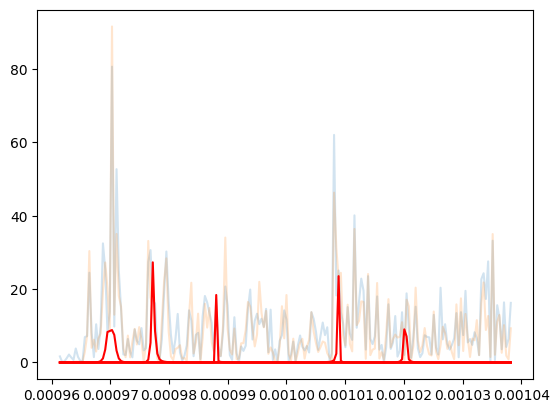

In [282]:
plt.plot(search_frequencies, np.abs(fake_data)**2 / Tobs, alpha=0.2)
plt.plot(search_frequencies, np.abs(fake_signals)**2 / Tobs, alpha=0.2)
for ii in np.where(source_snrs > rho_th)[0]:
    plt.plot(search_frequencies, np.abs(sources[ii])**2 / Tobs, c='r')
plt.show()

In [283]:
Ath, Sconf = get_threshold_and_conf_noise_for_powerlaw(Tobs, delta_f_band, psd_level, Nsources, alpha, rho_th, Alower, fdot_width)

In [284]:
print(Ath)

0.014328118


In [285]:
print(2 * np.mean(np.abs(fake_signals[10:-10])**2 / Tobs))
print(Sconf)

18.635618
18.173983


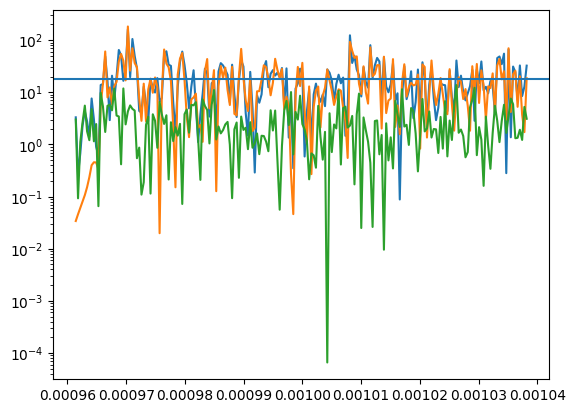

In [286]:
plt.plot(search_frequencies, 2 * np.abs(fake_data)**2 / Tobs)
plt.plot(search_frequencies, 2 * np.abs(fake_signals)**2 / Tobs)
plt.plot(search_frequencies, 2 * np.abs(fake_noise_fd)**2 / Tobs)
ax = plt.gca()
ax.axhline(Sconf)
plt.yscale("log")
plt.show()

In [287]:
# Fake sources
Sconfs = []
measureds = []
for ii in tqdm(range(100)):
    Alower = 1e-4

    Nsources = 10000
    source_params = {'f0': np.random.rand(Nsources) * (delta_f_band-10*df) + flow+10*df,
                    'fdot': priors.draw_from_fdot_gaussian(0, fdot_width, Nsources),
                    'A': priors.sample_power_law_bounded(4, Alower, 10, Nsources),
                    'phi0': np.random.randn(Nsources) * 2 * np.pi}

    freqs = np.fft.rfftfreq(Nsamples, d=delta_t)
    ilow = np.argmin(np.abs(freqs - flow))
    ihigh = ilow + Nbins

    # make fake data
    freqs, sources = waveform.chirp_template_fd_fft_batch(source_params,
                                                        Tobs,
                                                        Nsamples,
                                                        ilow=ilow,
                                                        ihigh=ihigh)

    fake_signals = np.sum(sources, axis=0)
    Ath, Sconf = get_threshold_and_conf_noise_for_powerlaw(Tobs, delta_f_band, psd_level, Nsources, alpha, rho_th, Alower, fdot_width)
    Sconfs.append(Sconf)
    measureds.append((2 * np.mean(np.abs(fake_signals[10:-10])**2 / Tobs)))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


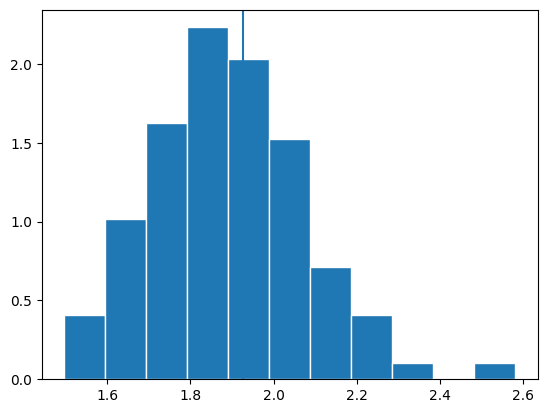

In [288]:
plt.hist(measureds, bins='auto', density=True, edgecolor='w')
ax = plt.gca()
ax.axvline(Sconfs[0])
plt.show()

In [266]:
print(np.mean(measureds), '+/-', np.std(measureds) / np.sqrt(len(measureds)))
print(np.mean(Sconfs))

1.9028827 +/- 0.020931562781333922
1.9257464
